In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from filelock import FileLock
import numpy as np
import ray
import sys
sys.path.append("../src/")
from consistent_hashing import ConsistentHash
import math 
from time import time
def get_data_loader():
    
    """Safely downloads data. Returns training/validation set dataloader."""
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    # We add FileLock here because multiple workers will want to
    # download data, and this may cause overwrites since
    # DataLoader is not threadsafe.
    
    class MNISTEvenOddDataset(torch.utils.data.Dataset):
        def __init__(self, ready_data):
            self.img_data = ready_data.data
            self.labels = ready_data.targets % 2
        
        def __len__(self):
            return len(self.labels)
    
        def __getitem__(self, ind):
            return torch.true_divide(self.img_data[ind].view(-1, 28 * 28).squeeze(), 255), torch.tensor([self.labels[ind]])


    
    with FileLock(os.path.expanduser("~/data.lock")):
        
        train_dataset = datasets.MNIST(
                "~/data", train=True, download=True, transform=mnist_transforms
            )
        
        test_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
        
        train_loader = torch.utils.data.DataLoader(
            MNISTEvenOddDataset(train_dataset),
            batch_size=128,
            shuffle=True,
        )
        test_loader = torch.utils.data.DataLoader(
             MNISTEvenOddDataset(test_dataset),
            batch_size=128,
            shuffle=False,
        )
    return train_loader, test_loader


def evaluate(model, test_loader):
    """Evaluates the accuracy of the model on a validation dataset."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # This is only set to finish evaluation faster.
            if batch_idx * len(data) > 1024:
                break
            outputs = nn.Sigmoid()(model(data))
            #_, predicted = torch.max(outputs.data, 1)
            predicted = outputs > 0.5
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100.0 * correct / total

In [12]:
class LinearNet(nn.Module):
    """Small Linear Network for MNIST."""

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc_weights = nn.ParameterList([nn.Parameter(torch.empty(1)) for weight in range(784)])
        init_fc = [nn.init.uniform_(x) for x in self.fc_weights]
        
        self.fc_bias = nn.Parameter(torch.empty(1))
        nn.init.uniform_(self.fc_bias)
        
    #def __init__(self):
    #    super(LinearNet, self).__init__()
    #    self.fc = nn.Linear(28*28, 1)
    #    nn.init.normal(self.fc.weight)

    #def forward(self, x):
    #    x = self.fc(x)
    #    return x
    
    def forward(self, x):
        #fc_layer = torch.cat(tuple(self.fc_weights)).unsqueeze(0)
        #x = x @ fc_layer.T + self.fc_bias
        for i, param in enumerate(self.fc_weights):
            if i==0:
                p=x[:,i]*param
            else:
                p += x[:,i]*param
        x = p.unsqueeze(1) + self.fc_bias
        return x
    
    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    def set_weights(self, keys, weights): 
        flatten_weights =  [item for sublist in weights for item in sublist]
        self.load_state_dict({keys[i]:flatten_weights[i] for i in range(len(keys))})
        
    def get_gradients(self, keys):
        grads = {}

        for name, p in self.named_parameters():
            if name in keys:
                grad = None if p.grad is None else p.grad.data.cpu().numpy()
                grads[name] = grad

        return [grads[key] for key in keys]

    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

In [40]:
@ray.remote  
class ParameterServer(object):
    def __init__(self, keys, values):
        self.weights = dict(zip(keys, values))

    def apply_gradients(self, keys, lr, *values):
        summed_gradients = [
            np.stack(gradient_zip).sum(axis=0) for gradient_zip in zip(*values)
        ]
    
        idx = 0
        for key, value in zip(keys, summed_gradients):
            self.weights[key] -= lr * torch.from_numpy(summed_gradients[idx])
            idx+=1

        return [self.weights[key] for key in keys]
    
    def add_weight(self, key, value):
        self.weights[key] = value
    
    def get_len(self):
        return len(self.weights)
    
    def get_weights(self, keys):
        return [self.weights[key] for key in keys]


In [57]:
@ray.remote
class DataWorker(object):
    def __init__(self, keys):
        self.model = LinearNet()
        self.data_iterator = iter(get_data_loader()[0])
        self.keys = keys
        self.key_set = set(self.keys)
        for key, value in dict(self.model.named_parameters()).items():
            if key not in self.key_set:
                value.requires_grad=False

        
    def update_weights(self, keys, *weights):
        self.model.set_weights(keys, weights)
        
#     def update_weights_selected(self, keys, *weights):
#         curr_state_dict = dict(self.model.state_dict().items())
#         flatten_weights =  [item for sublist in weights for item in sublist]
#         for i, key in enumerate(keys):
#             curr_state_dict[keys] = flatten_weights[i]
#         self.model.load_state_dict(curr_state_dict)
        
    def update_trainable(self, keys):
        self.keys = keys
        self.key_set = set(self.keys)
        for key, value in dict(self.model.named_parameters()).items():
            if key in self.key_set:
                value.requires_grad = True
            else:
                value.requires_grad = False
       

    def compute_gradients(self):
        #self.model.set_weights(keys, weights)
        try:
            data, target = next(self.data_iterator)
        except StopIteration:  # When the epoch ends, start a new epoch.
            self.data_iterator = iter(get_data_loader()[0])
            data, target = next(self.data_iterator)
        
        self.model.zero_grad()
        output = self.model(data)
        loss = nn.BCEWithLogitsLoss()(output, target.float())
        loss.backward()
        
        return self.model.get_gradients(self.keys)

In [85]:
iterations = 500
num_workers = 1 # number of workers per server
num_servers = 5 # number of servers
hashes_per_server = 100

def Scheduler(num_servers, hashes_per_server=50):
    
    model = LinearNet()
    key_values = model.get_weights()
    keys = np.array(list(key_values.keys()))
    #print(keys)
    #print(key_values) z
    values = [key_values[key] for key in keys]
    #values = [key_values[key] for key in keys]
    
    key_indices = {key: x for x, key in enumerate(keys)}
   
    # distributing weights across servers - do this using consistency hashing
    server_ids = ["server" + str(ind) for ind in range(num_servers)]
    hasher = ConsistentHash(keys, server_ids, hashes_per_server)
    servers = [ParameterServer.remote(keys[[key_indices[key] for key in hasher.get_keys_per_node()[serv]]], 
                                      [values[key_indices[key]] for key in hasher.get_keys_per_node()[serv]]) for serv in server_ids]
    # servers = [ParameterServer.remote(keys[0:1], values[0:1]), ParameterServer.remote(keys[1:2], values[1:2])]
    
    return hasher, servers, keys, model, hasher.get_keys_per_node(), server_ids.copy()

hasher, servers, keys, model, weight_assignments, server_ids =  Scheduler(num_servers, hashes_per_server)
ray.init(ignore_reinit_error=True)

# creating equal workers per server

workers = [[DataWorker.remote(weight_assignments["server" + str(j)]) for i in range(num_workers)] for j in range(num_servers)]





2022-05-31 09:13:57,597	INFO worker.py:963 -- Calling ray.init() again after it has already been called.


In [30]:
len(weight_assignments["server0"])

160

In [86]:
test_loader = get_data_loader()[1]


In [87]:
print("Running synchronous parameter server training.")
lr=0.1
failure_iter=501
failure_server="server4"

# we need to get a new keys order because we are not assuming a ordering in keys
current_weights = []
keys_order = []
acc_vals = []

for j in range(num_servers):
    keys_order.extend(weight_assignments["server" + str(j)])
    current_weights.extend(ray.get(servers[j].get_weights.remote(weight_assignments["server" + str(j)]))) 
curr_weights_ckpt = current_weights.copy()

time_per_iteration = []
for i in range(iterations):
 
    #start = time()
    
    if i == failure_iter:
        w0 = weight_assignments["server0"]
        #Define parameters that will need to be moved
        failure_params = weight_assignments[failure_server]
        #Delete server from hash ring and reassign params
        hasher.delete_node_and_reassign_to_others(failure_server)
        weight_assignments = hasher.get_keys_per_node()
        #Update servers and workers
        num_servers -= 1
        server_ind = server_ids.index(failure_server)
        server_ids = server_ids[0 : server_ind] + server_ids[server_ind + 1 : ]
        servers = servers[0 : server_ind] + servers[server_ind + 1 : ]
        workers = workers[0 : server_ind] + workers[server_ind + 1 : ]
        #Add each relevant parameter to its new server
        server_dict = {server_ids[x]:servers[x] for x in range(len(server_ids))}
        for ind, param in enumerate(failure_params):
            server_dict[hasher.get_key_to_node_map()[param]].add_weight.remote(param, curr_weights_ckpt[server_ind][ind])
        #Update these parameters for each worker to make them trainable
        [workers[j][idx].update_trainable.remote(weight_assignments["server" + str(j)]) for  idx  in range(num_workers) for j in range(num_servers)]
        [workers[j][idx].update_weights.remote(keys_order, *current_weights) for  idx  in range(num_workers) for j in range(num_servers)]
        
    
    # sync all weights on workers
    if i % 10 == 0:
        curr_weights_ckpt = current_weights.copy()
        # get weights from server
        #current_weights = [servers[j].get_weights.remote(weight_assignments["server" + str(j)]) for j in range(num_servers)] 

        # update weights on all workers
        [workers[j][idx].update_weights.remote(keys_order, *current_weights) for  idx  in range(num_workers) for j in range(num_servers)]
    
        
    # use local cache of weights and get gradients from workers
    gradients = [[workers[j][idx].compute_gradients.remote() for  idx  in range(num_workers)] for j in range(num_servers)]

#     start = time()
    if i == failure_iter:
        keys_order = []
        for j in range(num_servers):
            keys_order.extend(weight_assignments["server" + str(j)])

    # Updates gradients to specfic parameter servers
    current_weights_t = [servers[j].apply_gradients.remote(weight_assignments["server" + str(j)], lr, *gradients[j]) for j in range(num_servers)]
    current_weights = ray.get(current_weights_t)
    
    end = time()
    time_per_iteration.append(end-start)

    if i % 1 == 0:
        # Evaluate the current model.
        # current_weights = [servers[j].get_weights.remote(weight_assignments["server" + str(j)]) for j in range(num_servers)] 
      
        # we are once again using the server to key mapping to set the weight back
        model.set_weights(keys_order, current_weights)
        accuracy = evaluate(model, test_loader)
        acc_vals.append(accuracy)
        print("Iter {}: \taccuracy is {:.1f}".format(i, accuracy))
    #rint("\n")

#print("Final accuracy is {:.1f}.".format(accuracy))
# Clean up Ray resources and processes before the next example.
ray.shutdown()


Running synchronous parameter server training.
Iter 0: 	accuracy is 51.9
Iter 1: 	accuracy is 51.9
Iter 2: 	accuracy is 51.9
Iter 3: 	accuracy is 51.9
Iter 4: 	accuracy is 51.9
Iter 5: 	accuracy is 51.9
Iter 6: 	accuracy is 51.9
Iter 7: 	accuracy is 51.9
Iter 8: 	accuracy is 51.9
Iter 9: 	accuracy is 51.9
Iter 10: 	accuracy is 51.9
Iter 11: 	accuracy is 51.9
Iter 12: 	accuracy is 51.9
Iter 13: 	accuracy is 51.9
Iter 14: 	accuracy is 51.9
Iter 15: 	accuracy is 51.9
Iter 16: 	accuracy is 51.9
Iter 17: 	accuracy is 51.9
Iter 18: 	accuracy is 51.9
Iter 19: 	accuracy is 51.9
Iter 20: 	accuracy is 52.9
Iter 21: 	accuracy is 55.4
Iter 22: 	accuracy is 59.4
Iter 23: 	accuracy is 57.9
Iter 24: 	accuracy is 54.3
Iter 25: 	accuracy is 52.8
Iter 26: 	accuracy is 50.5
Iter 27: 	accuracy is 49.7
Iter 28: 	accuracy is 48.4
Iter 29: 	accuracy is 48.2
Iter 30: 	accuracy is 48.9
Iter 31: 	accuracy is 49.7
Iter 32: 	accuracy is 51.0
Iter 33: 	accuracy is 54.9
Iter 34: 	accuracy is 58.8
Iter 35: 	accuracy

Iter 295: 	accuracy is 85.9
Iter 296: 	accuracy is 85.0
Iter 297: 	accuracy is 85.2
Iter 298: 	accuracy is 84.9
Iter 299: 	accuracy is 84.0
Iter 300: 	accuracy is 85.0
Iter 301: 	accuracy is 85.3
Iter 302: 	accuracy is 85.3
Iter 303: 	accuracy is 85.9
Iter 304: 	accuracy is 85.2
Iter 305: 	accuracy is 84.6
Iter 306: 	accuracy is 83.9
Iter 307: 	accuracy is 83.3
Iter 308: 	accuracy is 82.7
Iter 309: 	accuracy is 82.1
Iter 310: 	accuracy is 83.1
Iter 311: 	accuracy is 83.6
Iter 312: 	accuracy is 84.5
Iter 313: 	accuracy is 85.1
Iter 314: 	accuracy is 85.5
Iter 315: 	accuracy is 85.2
Iter 316: 	accuracy is 85.5
Iter 317: 	accuracy is 84.4
Iter 318: 	accuracy is 83.9
Iter 319: 	accuracy is 83.2
Iter 320: 	accuracy is 83.9
Iter 321: 	accuracy is 84.5
Iter 322: 	accuracy is 85.3
Iter 323: 	accuracy is 85.7
Iter 324: 	accuracy is 85.8
Iter 325: 	accuracy is 84.5
Iter 326: 	accuracy is 83.4
Iter 327: 	accuracy is 82.2
Iter 328: 	accuracy is 81.5
Iter 329: 	accuracy is 80.0
Iter 330: 	accuracy 

In [33]:
np.mean(time_per_iteration[1:])

0.1470847402163641

In [27]:
np.std(time_per_iteration[1:])

0.02577144327194029

In [20]:
time_per_iteration

[3.588714361190796,
 0.13730883598327637,
 0.13313031196594238,
 0.1397244930267334,
 0.13124918937683105,
 0.1424236297607422,
 0.13758516311645508,
 0.13960599899291992,
 0.13950729370117188,
 0.1336812973022461,
 0.19435453414916992,
 0.13529610633850098,
 0.14109039306640625,
 0.13781523704528809,
 0.1302502155303955,
 0.13529276847839355,
 0.13292670249938965,
 0.13463830947875977,
 0.14171147346496582,
 0.14144682884216309,
 0.19423699378967285,
 0.12644362449645996,
 0.1280200481414795,
 0.12221574783325195,
 0.12069988250732422,
 0.12054061889648438,
 0.12222146987915039,
 0.18278765678405762,
 0.19629263877868652,
 0.12352895736694336,
 0.19074463844299316,
 0.12006068229675293,
 0.12671160697937012,
 0.12433290481567383,
 0.1338052749633789,
 0.1232297420501709,
 0.12189030647277832,
 0.12937450408935547,
 0.1230320930480957,
 0.12760472297668457,
 0.1854264736175537,
 0.11983871459960938,
 0.12497305870056152,
 0.12382173538208008,
 0.1202993392944336,
 0.1263740062713623,
 

In [12]:
server_ids

['server0', 'server1', 'server2', 'server3']

In [13]:
server_ids.index("server4")

ValueError: 'server4' is not in list

In [ ]:
hasher.get_key_to_node_map()['fc_bias']

In [28]:
testmodel=LinearNet()

In [31]:
dict(testmodel.state_dict().items())

{'fc_bias': tensor([0.7625]),
 'fc_weights.0': tensor([0.5567]),
 'fc_weights.1': tensor([0.0267]),
 'fc_weights.2': tensor([0.4424]),
 'fc_weights.3': tensor([0.3825]),
 'fc_weights.4': tensor([0.5311]),
 'fc_weights.5': tensor([0.8576]),
 'fc_weights.6': tensor([0.5620]),
 'fc_weights.7': tensor([0.6615]),
 'fc_weights.8': tensor([0.6206]),
 'fc_weights.9': tensor([0.9785]),
 'fc_weights.10': tensor([0.6421]),
 'fc_weights.11': tensor([0.5424]),
 'fc_weights.12': tensor([0.9489]),
 'fc_weights.13': tensor([0.4326]),
 'fc_weights.14': tensor([0.2355]),
 'fc_weights.15': tensor([0.8898]),
 'fc_weights.16': tensor([0.9719]),
 'fc_weights.17': tensor([0.9767]),
 'fc_weights.18': tensor([0.2998]),
 'fc_weights.19': tensor([0.6725]),
 'fc_weights.20': tensor([0.8768]),
 'fc_weights.21': tensor([0.7303]),
 'fc_weights.22': tensor([0.6391]),
 'fc_weights.23': tensor([0.6964]),
 'fc_weights.24': tensor([0.4810]),
 'fc_weights.25': tensor([0.3722]),
 'fc_weights.26': tensor([0.8999]),
 'fc_wei

In [ ]:
len(current_weights[0])

In [ ]:
servers[0].weights

In [ ]:
sum([184, 198, 191, 212])

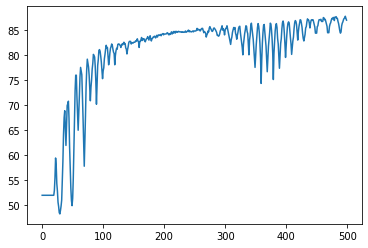

In [90]:
import matplotlib.pyplot as plt
plt.plot(acc_vals)